In [1]:
from share import *
import config

import os
import cv2
import einops
import gradio as gr
import numpy as np
import torch
import random

from pytorch_lightning import seed_everything

from annotator.util import resize_image, HWC3
from annotator.hed import HEDdetector
from annotator.uniformer import UniformerDetector
from annotator.midas import MidasDetector
from annotator.canny import CannyDetector

from cldm.model import create_model, load_state_dict
from cldm.ddim_hacked import DDIMSampler

from PIL import Image

from fastai.basics import show_image, show_images
from torchvision.utils import make_grid

logging improved.


## Load Annotators and Pretrained Models

In [2]:
apply_hed = HEDdetector()
apply_uniformer = UniformerDetector()
apply_midas = MidasDetector()
apply_canny = CannyDetector()

model = create_model('./models/cldm_v15.yaml').cpu()
model.load_state_dict(load_state_dict('./ckpts/network-step=04999.ckpt', location='cuda'))
# model.load_state_dict(load_state_dict('./ckpts/last.ckpt', location='cuda'))
model = model.cuda()
ddim_sampler = DDIMSampler(model)

Use Checkpoint: False
Checkpoint Number: [0, 0, 0, 0]
Use global window for all blocks in stage3
load checkpoint from local path: /mnt/e/GitHub/Prompt-Diffusion/annotator/ckpts/upernet_global_small.pth
No module 'xformers'. Proceeding without it.
ControlLDM: Running in eps-prediction mode
DiffusionWrapper has 859.52 M params.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 4, 32, 32) = 4096 dimensions.
making attention of type 'vanilla' with 512 in_channels
Loaded model config from [./models/cldm_v15.yaml]
Loaded state_dict from [./ckpts/cfg-step=000004999.ckpt]


## Define Sampling Functions

In [3]:
def prepair_input(input_image, example_image, task, resolution=512, input_source=None, example_source=None):
    input_image = resize_image(HWC3(np.array(Image.open(input_image))), resolution)
    example_image = resize_image(HWC3(np.array(Image.open(example_image))), resolution)
    H, W, C = input_image.shape
    
    # Prepair Input Image Hint
    if input_source is not None:
        input_source = HWC3(np.array(Image.open(input_source)))
        detected_map = cv2.resize(input_source, (W, H), interpolation=cv2.INTER_LINEAR)
    elif task == 'inv_hed':
        detected_map = apply_hed(input_image)
    elif task == 'inv_seg':
        detected_map = apply_uniformer(input_image)
    elif task == 'inv_depth':
        detected_map, _ = apply_midas(input_image)
    elif task == 'inv_normal':
        _, detected_map = apply_midas(input_image)
    elif task == 'inv_canny':
        detected_map = apply_canny(input_image, 100, 200)
    elif task in ['hed', 'seg', 'depth', 'normal']:
        detected_map = input_image
        
    query = 2 * torch.from_numpy(HWC3(detected_map.copy())).float().cuda() / 255.0 - 1.0
    
    if example_source is not None:
        example_source = HWC3(np.array(Image.open(example_source)))
        example_source = cv2.resize(example_source, (W, H), interpolation=cv2.INTER_LINEAR)
        example = np.concatenate([example_source, example_image], axis=2)  # h w c
    elif task == 'inv_hed':
        example_source = HWC3(apply_hed(example_image))
        example = np.concatenate([example_source, example_image], axis=2)  # h w c
    elif task == 'inv_seg':
        example_source = HWC3(apply_uniformer(example_image))
        example = np.concatenate([example_source, example_image], axis=2)  # h w c
    elif task == 'inv_depth':
        example_source, _ = apply_midas(example_image)
        example = np.concatenate([HWC3(example_source), example_image], axis=2)  # h w c
    elif task == 'inv_normal':
        _, example_source = apply_midas(example_image)
        example = np.concatenate([HWC3(example_source), example_image], axis=2)  # h w c
    elif task == 'inv_canny':
        example_source = HWC3(apply_canny(example_image, 100, 200))
        example = np.concatenate([example_source, example_image], axis=2)  # h w c
    elif task == 'hed':
        example_source = HWC3(apply_hed(example_image))
        example = np.concatenate([example_image, example_source], axis=2)  # h w c
    elif task == 'seg':
        example_source = HWC3(apply_uniformer(example_image))
        example = np.concatenate([example_image, example_source], axis=2)  # h w c
    elif task == 'depth':
        example_source, _ = apply_midas(example_image)
        example = np.concatenate([example_image, HWC3(example_source)], axis=2)  # h w c
    elif task == 'normal':
        _, example_source = apply_midas(example_image)
        example = np.concatenate([example_image, HWC3(example_source)], axis=2)  # h w c
    
    example = 2 * torch.from_numpy(example.copy()).float().cuda() / 255.0 - 1.0
    
    return query, example


In [4]:
def process(input_image, example_image, task, input_source, example_source, 
            prompt, a_prompt, n_prompt, num_samples,
            image_resolution, detect_resolution,
            ddim_steps, guess_mode, strength, seed, eta, scale=1.0):
    with torch.no_grad():
        
        query_init, example = prepair_input(input_image, example_image, task=task, resolution=image_resolution, 
                                            input_source=input_source, example_source=example_source)
        H, W, C = query_init.shape
        
        query = torch.stack([query_init] * num_samples, dim=0)
        query = einops.rearrange(query, 'b h w c -> b c h w').clone()
        
        example = torch.stack([example] * num_samples, dim=0)
        example = einops.rearrange(example, 'b h w c -> b c h w').clone()
        
        print(query.shape, example.shape)
        
        
        if seed == -1:
            seed = random.randint(0, 65535)
        seed_everything(seed)

        if config.save_memory:
            model.low_vram_shift(is_diffusing=False)
            
        cond = {"c_crossattn":  [model.get_learned_conditioning([prompt + ', ' + a_prompt] * num_samples)],
                "example_pair": [example],
                "query":        [query]}

        un_cond = {"c_crossattn":  [model.get_learned_conditioning([n_prompt] * num_samples)],
                   "example_pair": [example],
                   "query":        [query]}
        
        shape = (4, H // 8, W // 8)

        if config.save_memory:
            model.low_vram_shift(is_diffusing=True)

        model.control_scales = [strength * (0.825 ** float(12 - i)) for i in range(13)] if guess_mode else ([strength] * 13)  # Magic number. IDK why. Perhaps because 0.825**12<0.01 but 0.826**12>0.01
        samples, intermediates = ddim_sampler.sample(ddim_steps, num_samples,
                                                     shape, cond, verbose=False, eta=eta,
                                                     unconditional_guidance_scale=scale,
                                                     unconditional_conditioning=un_cond)

        if config.save_memory:
            model.low_vram_shift(is_diffusing=False)

        x_samples = model.decode_first_stage(samples)
        x_samples = (einops.rearrange(x_samples, 'b c h w -> b h w c') * 127.5 + 127.5).cpu().numpy().clip(0, 255).astype(np.uint8)
        
        query_init = (query_init * 127.5 + 127.5).cpu().numpy().clip(0, 255).astype(np.uint8)
        results = [x_samples[i] for i in range(num_samples)]
        
    return [query_init] + results


## Hyperparameters for Sampling

In [5]:
num_samples = 1
image_resolution = 512
strength = 1.0
guess_mode = False
detect_resolution = 512
ddim_steps = 100
seed = 1
eta = 0.0
scale = 9.0

os.makedirs('./generated_images', exist_ok=True)

## Inverse Tasks

Global seed set to 1


torch.Size([3, 3, 512, 512]) torch.Size([3, 6, 512, 512])
Data shape for DDIM sampling is (3, 4, 64, 64), eta 0.0
Running DDIM Sampling with 100 timesteps


DDIM Sampler: 100%|███████████████████████████████████████████████████████████| 100/100 [00:30<00:00,  3.24it/s]


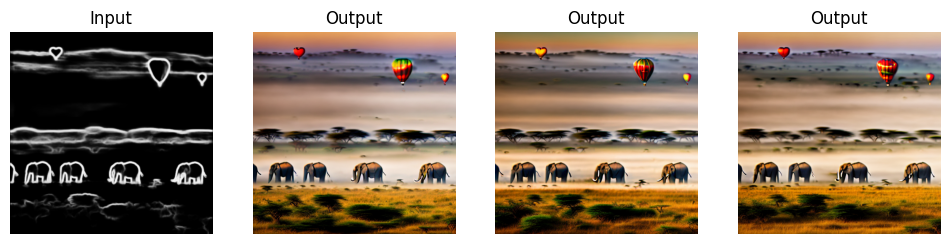

In [6]:
task = 'inv_hed'

input_image = './images_to_try/00.jpg'
example_image = './images_to_try/04.jpg'
input_source = None
example_source = None

prompt = "African elephant,  foggy morning, hot air balloons landing on background,  Masai Mara National Reserve, Kenya Reklamní fotografie"
a_prompt = 'best quality, extremely detailed'
n_prompt = 'longbody, lowres, bad anatomy, bad hands, missing fingers, extra digit, fewer digits, cropped, worst quality, low quality'
seed = 1
num_samples = 3

result = process(input_image, example_image, task, input_source, example_source,
                 prompt, a_prompt, n_prompt,
                 num_samples, image_resolution, detect_resolution,
                 ddim_steps, guess_mode, strength, seed, eta,
                 scale=scale)

# Image.fromarray(result[0]).save(f"./generated_images/{task}_input_{input_image.split('/')[-1].split(',')[0]}")
# Image.fromarray(result[1]).save(f"./generated_images/{task}_output_{input_image.split('/')[-1].split(',')[0]}")

show_images(result, titles=['Input']+['Output']*(num_samples))

## Forward Tasks

Global seed set to 1


torch.Size([3, 3, 512, 512]) torch.Size([3, 6, 512, 512])
Data shape for DDIM sampling is (3, 4, 64, 64), eta 0.0
Running DDIM Sampling with 100 timesteps


DDIM Sampler: 100%|███████████████████████████████████████████████████████████| 100/100 [00:30<00:00,  3.25it/s]


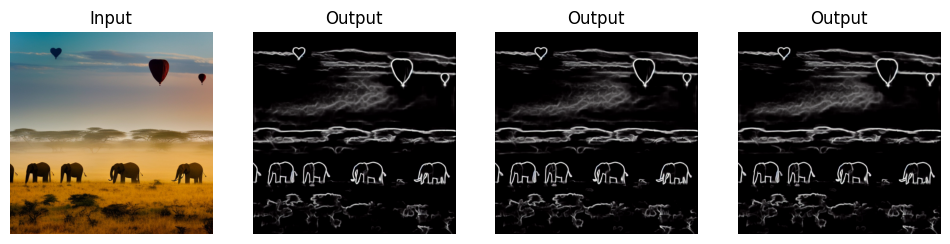

In [7]:
task = 'hed'

input_image = './images_to_try/00.jpg'
example_image = './images_to_try/04.jpg'

input_source = None
example_source = None

prompt = "hed map"
a_prompt = 'best quality, extremely detailed'
n_prompt = 'longbody, lowres, bad anatomy, bad hands, missing fingers, extra digit, fewer digits, cropped, worst quality, low quality'
seed = 1
num_samples = 3

result = process(input_image, example_image, task, input_source, example_source,
                 prompt, a_prompt, n_prompt,
                 num_samples, image_resolution, detect_resolution,
                 ddim_steps, guess_mode, strength, seed, eta,
                 scale=scale)

# Image.fromarray(result[0]).save(f"./generated_images/{task}_input_{input_image.split('/')[-1].split(',')[0]}")
# Image.fromarray(result[1]).save(f"./generated_images/{task}_output_{input_image.split('/')[-1].split(',')[0]}")

show_images(result, titles=['Input']+['Output']*(num_samples))

## Generalization to New Tasks

Global seed set to 1


torch.Size([3, 3, 512, 512]) torch.Size([3, 6, 512, 512])
Data shape for DDIM sampling is (3, 4, 64, 64), eta 0.0
Running DDIM Sampling with 100 timesteps


DDIM Sampler: 100%|███████████████████████████████████████████████████████████| 100/100 [00:30<00:00,  3.25it/s]


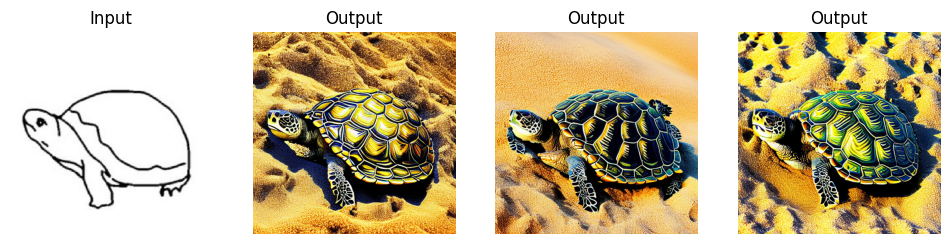

In [8]:
input_image = './images_to_try/new_01.png' # when input_source given, not used
input_source = './images_to_try/new_01.png'

example_image = './images_to_try/house.png'
example_source = './images_to_try/house_line.png'

task = 'new tasks'
prompt = "a turtle stands on the beach"
a_prompt = 'best quality, extremely detailed'
n_prompt = 'longbody, lowres, bad anatomy, bad hands, missing fingers, extra digit, fewer digits, cropped, worst quality, low quality'
seed = 1
num_samples = 3

result = process(input_image, example_image, task, input_source, example_source,
                 prompt, a_prompt, n_prompt,
                 num_samples, image_resolution, detect_resolution,
                 ddim_steps, guess_mode, strength, seed, eta,
                 scale=scale)

# Image.fromarray(result[0]).save(f"./generated_images/{task}_input_{input_image.split('/')[-1].split(',')[0]}")
# Image.fromarray(result[1]).save(f"./generated_images/{task}_output_{input_image.split('/')[-1].split(',')[0]}")

show_images(result, titles=['Input']+['Output']*(num_samples))

## Two Step Image-Editing

Global seed set to 0


torch.Size([1, 3, 512, 512]) torch.Size([1, 6, 512, 512])
Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 100 timesteps


DDIM Sampler: 100%|███████████████████████████████████████████████████████████| 100/100 [00:11<00:00,  8.45it/s]


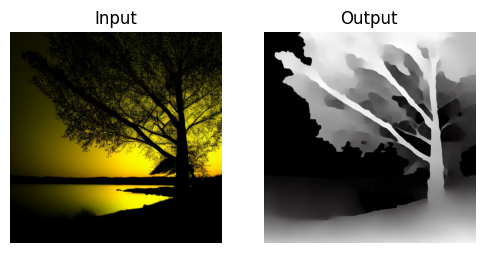

In [9]:
input_image = './images_to_try/image_edit_01.jpg'
example_image = './images_to_try/01.jpg'
input_source = None
example_source = None

f_task = 'depth'
prompt = "depth map"  # depth map, segmentation map, hed map
a_prompt = 'best quality, extremely detailed'
n_prompt = 'longbody, lowres, bad anatomy, bad hands, missing fingers, extra digit, fewer digits, cropped, worst quality, low quality'
seed = 0
num_samples = 1

result = process(input_image, example_image, f_task, input_source, example_source,
                 prompt, a_prompt, n_prompt,
                 num_samples, image_resolution, detect_resolution,
                 ddim_steps, guess_mode, strength,
                 seed, eta, scale)

Image.fromarray(result[1]).save(f"./images_to_try/image_edit_ouput_{f_task}_{input_image.split('/')[-1].split('.')[0]}.jpg")
show_images(result, titles=['Input']+['Output']*(num_samples))

Global seed set to 0


torch.Size([3, 3, 512, 512]) torch.Size([3, 6, 512, 512])
Data shape for DDIM sampling is (3, 4, 64, 64), eta 0.0
Running DDIM Sampling with 100 timesteps


DDIM Sampler: 100%|███████████████████████████████████████████████████████████| 100/100 [00:31<00:00,  3.23it/s]


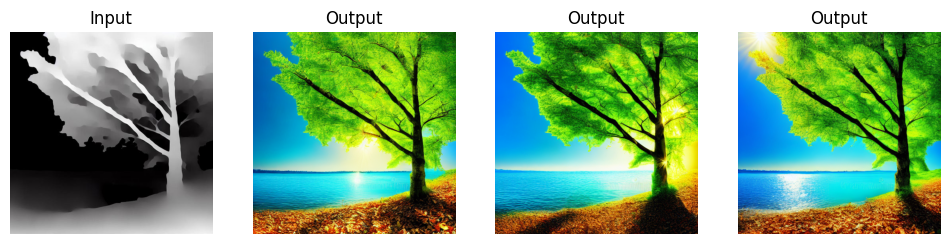

In [10]:
input_source = f"./images_to_try/image_edit_ouput_{f_task}_{input_image.split('/')[-1].split('.')[0]}.jpg"

task = 'inv_depth'
prompt = "tree, shore, leaves in a sunny day"
a_prompt = 'best quality, extremely detailed'
n_prompt = 'longbody, lowres, bad anatomy, bad hands, missing fingers, extra digit, fewer digits, cropped, worst quality, low quality'
seed = 0
num_samples = 3

result = process(input_image, example_image, task, input_source, example_source,
                 prompt, a_prompt, n_prompt,
                 num_samples, image_resolution, detect_resolution,
                 ddim_steps, guess_mode, strength,
                 seed, eta, scale)

# Image.fromarray(result[1]).save(f"./generated_images/{task}_edit_{input_image.split('/')[-1].split(',')[0]}.jpg")

show_images(result, titles=['Input']+['Output']*(num_samples))